In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow.keras.backend as K

"""
this function load the database saved in the folder 'dir'; the database is a
defined by two pickle files: one for the images, one for the labels.
"""
def loadDB():
    # the dir path has to be changed!
    dir = "db/mma/"
    wopen = dir + "train"
    pickle_in = open(wopen+"X.pickle", "rb")
    datax = pickle.load(pickle_in)
    pickle_in = open(wopen+"Y.pickle", "rb")
    datay = pickle.load(pickle_in)
    datay = np.array(datay).reshape(-1)
    print("np.array db img shape: " + str(datax.shape))
    print("np.array db labels shape: " + str(datay.shape))
    return datax, datay

"""
this function build the generator
"""
def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [256, 128, 64, 1]
    stride = 2
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0]*2)(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]*2))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 64:
            stride = 1
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=stride,
                            padding='same', kernel_initializer=init)(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator

"""
this function build the discriminator
"""
def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128]
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

"""
this function perform SGD on the adversarial model; the parameters to
be specified are: batch_size, latent_size, train_steps, num_labels, model_name.
After training and every 'save_model' iteration the generator is saved.
"""
def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # when the train_step mod save_interval == 0, the code print loss and accuracy
    # and call plot_images; in this way I can track the performance of the network
    save_interval = 500
    # when the train_step mod save_model == 0, the code save the model and call
    # test_generator function
    save_model = 10000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        fake_images = generator.predict([noise, fake_labels])
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0

        # train discriminator
        # the discriminator is trained using fake_images and real_images
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i+1, loss, acc)
        discriminator.trainable = False
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        y = np.ones([batch_size, 1])
        loss = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f]" % (log, loss)
        if i == (train_steps - 1) or (i+1) % save_interval == 0:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
        if (i+1) % save_model == 0:
            # save the generator
            generator.save("gen")
            # test generator
            test_generator(generator, tag=i)
    # in the end we save generator
    generator.save("gen")

"""
this function plot the generator output for a given 'z' noise_input vector,
and 'label' noise_class vector. The plot is saved as png.
"""
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%d.png" % step)
    images = generator.predict([noise_input, noise_class])
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r, c) = (7, 3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

"""
This function build the models and train them.
if reause=true this function will load saved models and continue training.
After training the generator will be saved.
"""
def build_and_train_models(reuse):
    x_train, y_train = loadDB()
    # reshape data as (28, 28, 1) and normalize in [0,1]
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    # network parameters
    model_name = "cgan"
    latent_size = 100
    batch_size = 64
    train_steps = 20
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
        discriminator = load_model("dis")
    print(discriminator.summary())

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
        generator = load_model("gen")
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer)
    #adversarial.summary()

    #visual plot models
    #plot_model(generator, to_file='generator.png',
    #           show_shapes=True, show_layer_names=True)
    #plot_model(discriminator, to_file='discriminator.png',
    #           show_shapes=True, show_layer_names=True)
    #plot_model(adversarial, to_file='adversarial.png',
    #           show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, tag=0):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 100])
    # one-hot encoding of the test labels (3 array for each label)
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=False,
                step=tag,
                model_name="test_outputs")


if __name__ == '__main__':
    build_and_train_models(reuse=False)


np.array db img shape: (92968, 28, 28, 1)
np.array db labels shape: (92968,)
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          6272        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
_________

In [ ]:
"""
#CREAZIONE PICKLE GRAYSCALE DA DB

import os
import cv2
from numpy import asarray
import PIL

data = []
wat = "train"
categorie = ['angry', 'disgust','fear', 'happy','neutral','sad','surprise']
datadir = "/content/MMAFEDB/" + wat
def create_data():
  for category in categorie:
    path = os.path.join(datadir, category)
    class_num = categorie.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (28,28))
        data.append([new_array, class_num])
      except Exception as e:
        print(e)

create_data()

import numpy as np
x = []
y = []
for f,l in data:
  x.append(f)
  y.append(l)

x = np.array(x).reshape(-1,28,28,1)

import pickle
pickle_out = open(wat+"X.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open(wat+"Y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()
"""

np.array db img shape: (121677, 28, 28, 1)
np.array db labels shape: (121677,)

Esempio:

label: 0


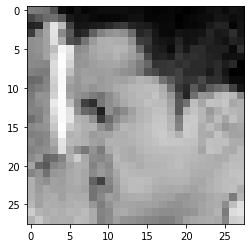

In [ ]:
"""Lettura pickle grayscale e plot"""

import pickle
import matplotlib.pyplot as plt
import numpy as np

dir="/content/drive/MyDrive/Università/Anno4/Affective Computing/fuse/"
wopen= dir + "fuse"
pickle_in = open(wopen+"X.pickle","rb")
datax = pickle.load(pickle_in)
pickle_in = open(wopen+"Y.pickle","rb")
datay = pickle.load(pickle_in)
datay = np.array(datay).reshape(-1)
print("np.array db img shape: " + str(datax.shape))
print("np.array db labels shape: " + str(datay.shape))

print("\nEsempio:\n")
plt.imshow(datax[0].squeeze(), cmap='gray')
print("label: " + str(datay[0]))

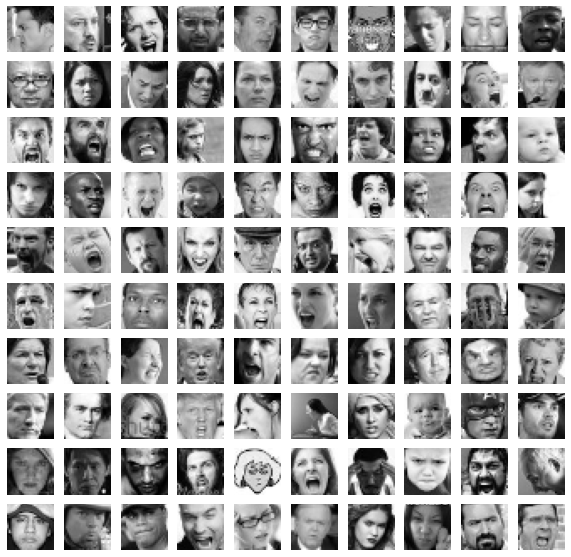

In [ ]:
"""Plot multiplo di np array grayscale"""

import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(w, h))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(datax[i-1].squeeze(), cmap='gray')
plt.show()

10: [discriminator loss: 0.005098, acc: 1.000000] [adversarial loss: 0.426864, acc: 1.000000]
cgan  labels for generated images:  [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6]


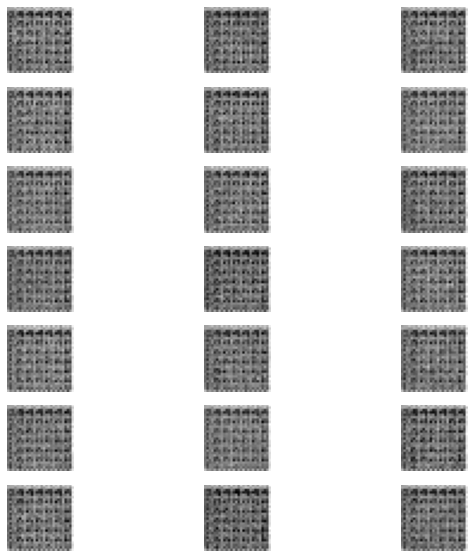

INFO:tensorflow:Assets written to: gen/assets


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse


def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [256, 128, 64, 1]
    stride = 2
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0]*2)(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]*2))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 64:
          stride = 1
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides= stride,
                            padding='same')(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128]
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
                kernel_size=kernel_size,
                strides=2,
                padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
                kernel_size=kernel_size,
                strides=2,
                padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
                kernel_size=kernel_size,
                strides=2,
                padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 1000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
        fake_images = generator.predict([noise, fake_labels])
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0

        #train discriminator
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i+1, loss, acc)
        discriminator.trainable = False
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        if i == train_steps - 1:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=True,
                        step=(i + 1),
                        model_name=model_name)

    # save the generator
    generator.save("gen")


def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    #os.makedirs(model_name, exist_ok=True)
    #filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r,c) = (7,3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    #plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(reuse):
    x_train = datax
    y_train = datay
    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan"
    # network parameters
    latent_size = 100
    batch_size = 32
    train_steps = 10
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
      discriminator = load_model("dis")
    #discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
      generator = load_model("gen")
    #generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    #adversarial.summary()

    # visual plot models
    plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True)
    plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)
    plot_model(adversarial, to_file='adversarial.png', show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    # routine infinita
    train(models, data, params)
    #salvare ogni fine train


def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 100])
    step = 0
    num_labels = 7
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")


if __name__ == '__main__':
    ### TRAIN CGAN ###
    build_and_train_models(reuse=False)
    #tot = 1
    #for i in range(tot):
      #loadmodels()
      #print("--- stage [", i+1, " / ", tot, "] ---")
      #build_and_train_models(reuse=True)
      #savemodels()

    ### TEST CGAN ###
    #generator = load_model("gen")
    #test_generator(generator)

In [ ]:
""" save f5 models in drive """
def savemodels():
  !rm -r /content/drive/MyDrive/Università/Anno4/Affective\ Computing/model/*
  !sleep 1
  !cp -ar ./gen/ /content/drive/MyDrive/Università/Anno4/Affective\ Computing/model
  !cp -ar ./dis/ /content/drive/MyDrive/Università/Anno4/Affective\ Computing/model
  print("###  saved models  ###")

#savemodels()

In [ ]:
""" load h5 models from drive  """
def loadmodels():
  !rm -r ./gen
  !rm -r ./dis
  !sleep 1
  !cp -ar /content/drive/MyDrive/Università/Anno4/Affective\ Computing/model/gen/ ./
  !cp -ar /content/drive/MyDrive/Università/Anno4/Affective\ Computing/model/dis/ ./
  print("###  loaded models  ###")

#loadmodels()

In [ ]:
### test server ###

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow.keras.backend as K


def loadDB():
    dir = "/content/drive/MyDrive/Università/Anno4/Affective Computing/mma/"
    wopen = dir + "train"
    pickle_in = open(wopen+"X.pickle", "rb")
    datax = pickle.load(pickle_in)
    pickle_in = open(wopen+"Y.pickle", "rb")
    datay = pickle.load(pickle_in)
    datay = np.array(datay).reshape(-1)
    print("np.array db img shape: " + str(datax.shape))
    print("np.array db labels shape: " + str(datay.shape))
    return datax, datay

def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [256, 128, 64, 1]
    stride = 2
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0]*2)(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]*2))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 64:
            stride = 1
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=stride,
                            padding='same')(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128]
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 1000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        fake_images = generator.predict([noise, fake_labels])
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0

        # train discriminator
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i+1, loss, acc)
        discriminator.trainable = False
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        if i == train_steps - 1 or i+1 % save_interval == 0:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
    # save the generator
    generator.save("gen")


def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%d.png" % step)
    images = generator.predict([noise_input, noise_class])
    #print(model_name, " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r, c) = (7, 3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(reuse):
    x_train, y_train = loadDB()
    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan"
    # network parameters
    latent_size = 100
    batch_size = 32
    train_steps = 10
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # fix session
    # K.clear_session()

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
        discriminator = load_model("dis")
    # print(discriminator.summary())

    # K.clear_session()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
        generator = load_model("gen")
    # generator.summary()

    # K.clear_session()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    # adversarial.summary()

    # visual plot models
    # plot_model(generator, to_file='generator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(discriminator, to_file='discriminator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(adversarial, to_file='adversarial.png',
    #           show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    # routine infinita
    train(models, data, params)
    # salvare ogni fine train
    # test_generator ogni fine train del gen


def test_generator(generator, tag=0):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 100])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=False,
                step=tag,
                model_name="testoutputs")


if __name__ == '__main__':
    ### TRAIN CGAN ###
    build_and_train_models(reuse=False)
    #tot = 1
    # for i in range(tot):
    # loadmodels()
    #print("--- stage [", i+1, " / ", tot, "] ---")
    # build_and_train_models(reuse=True)
    # savemodels()

    ### TEST CGAN ###
    #generator = load_model("gen")
    #test_generator(generator)


np.array db img shape: (92968, 28, 28, 1)
np.array db labels shape: (92968,)
10: [discriminator loss: 0.014275, acc: 1.000000] [adversarial loss: 0.455018, acc: 1.000000]
INFO:tensorflow:Assets written to: gen/assets


In [ ]:
### test 2 con fix learning ###

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow.keras.backend as K


def loadDB():
    dir = "/content/drive/MyDrive/Università/Anno4/Affective Computing/db/mma/"
    wopen = dir + "train"
    pickle_in = open(wopen+"X.pickle", "rb")
    datax = pickle.load(pickle_in)
    pickle_in = open(wopen+"Y.pickle", "rb")
    datay = pickle.load(pickle_in)
    datay = np.array(datay).reshape(-1)
    print("np.array db img shape: " + str(datax.shape))
    print("np.array db labels shape: " + str(datay.shape))
    return datax, datay


def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [256, 128, 64, 1]
    stride = 2
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0]*2)(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]*2))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 64:
            stride = 1
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=stride,
                            padding='same', kernel_initializer=init)(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128]
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 500
    save_model = 10000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        fake_images = generator.predict([noise, fake_labels])
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0

        # train discriminator
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i+1, loss, acc)
        discriminator.trainable = False
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        y = np.ones([batch_size, 1])
        loss = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f]" % (log, loss)
        if i == (train_steps - 1) or (i+1) % save_interval == 0:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
        if (i+1) % save_model == 0:
            # save the generator
            generator.save("gen")
            # test generator
            test_generator(generator, tag=i)
    # in the end we save generator
    generator.save("gen")


def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%d.png" % step)
    images = generator.predict([noise_input, noise_class])
    #print(model_name, " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r, c) = (7, 3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(reuse):
    x_train, y_train = loadDB()
    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan"
    # network parameters
    latent_size = 100
    batch_size = 64
    train_steps = 20
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
        discriminator = load_model("dis")
    print(discriminator.summary())

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
        generator = load_model("gen")
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer)
    #adversarial.summary()

    #visual plot models
    plot_model(generator, to_file='generator.png',
               show_shapes=True, show_layer_names=True)
    plot_model(discriminator, to_file='discriminator.png',
               show_shapes=True, show_layer_names=True)
    plot_model(adversarial, to_file='adversarial.png',
               show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, tag=0):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 100])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=False,
                step=tag,
                model_name="test_outputs")


if __name__ == '__main__':
    ### TRAIN CGAN ###
    build_and_train_models(reuse=False)


np.array db img shape: (92968, 28, 28, 1)
np.array db labels shape: (92968,)
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          6272        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
_________

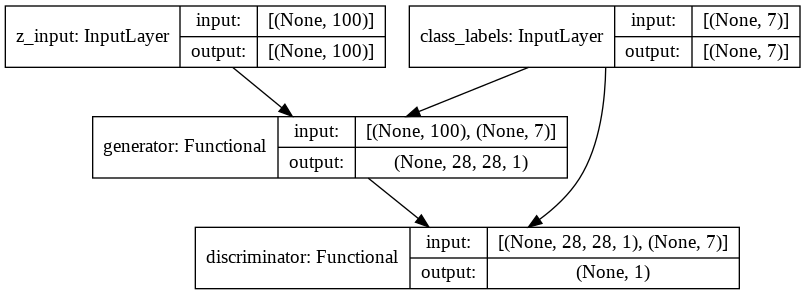

---


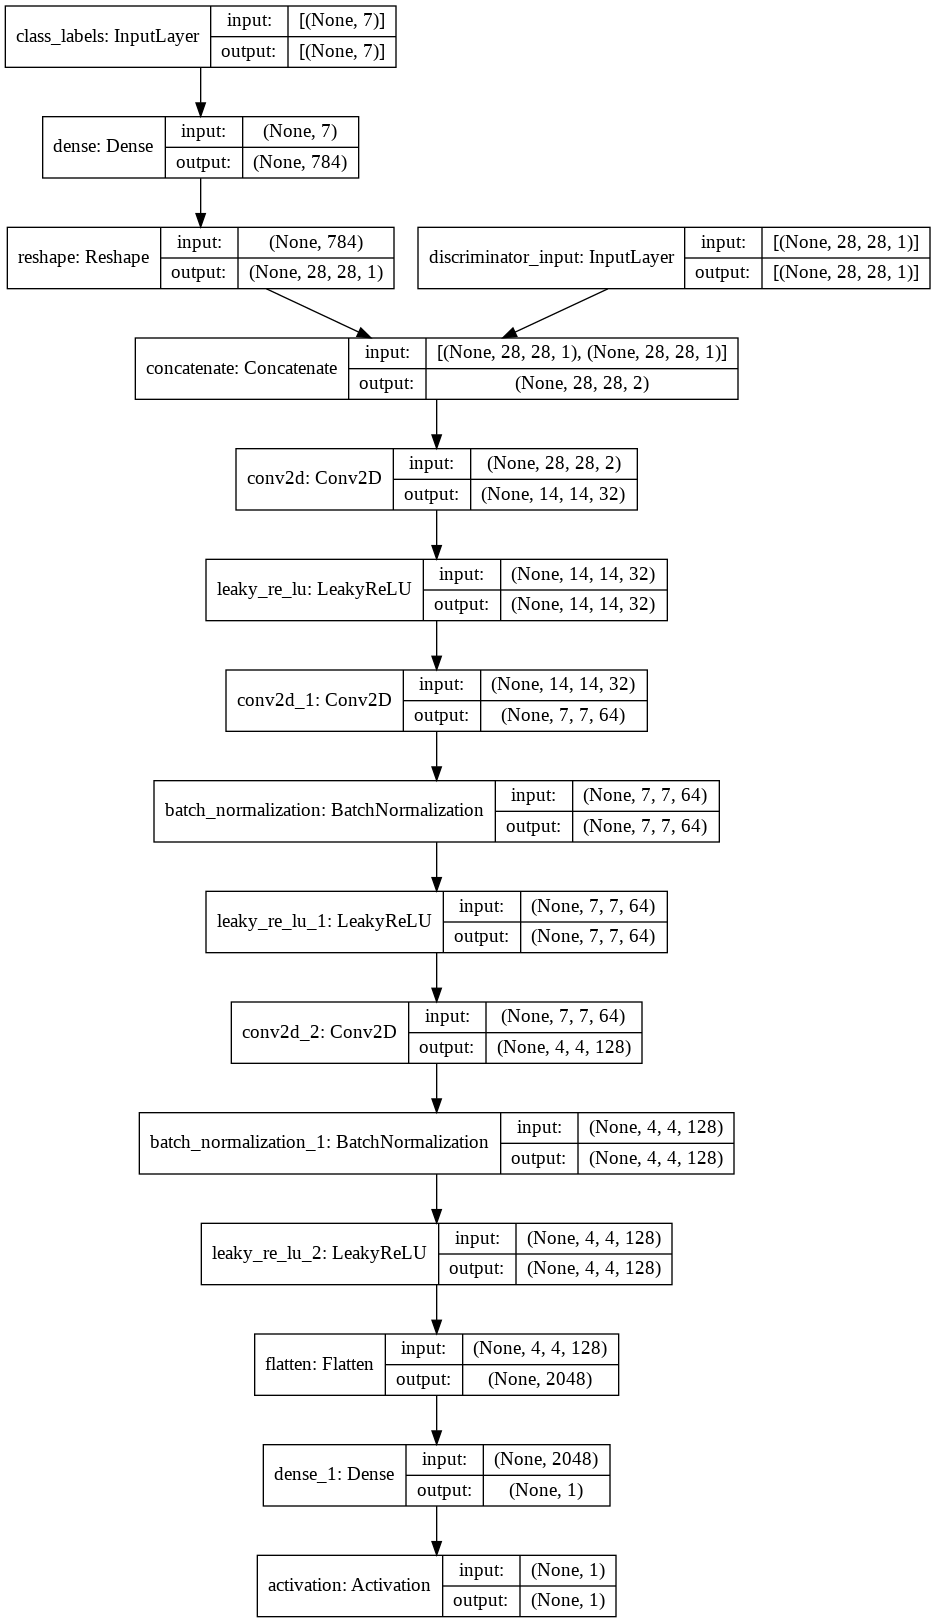

---


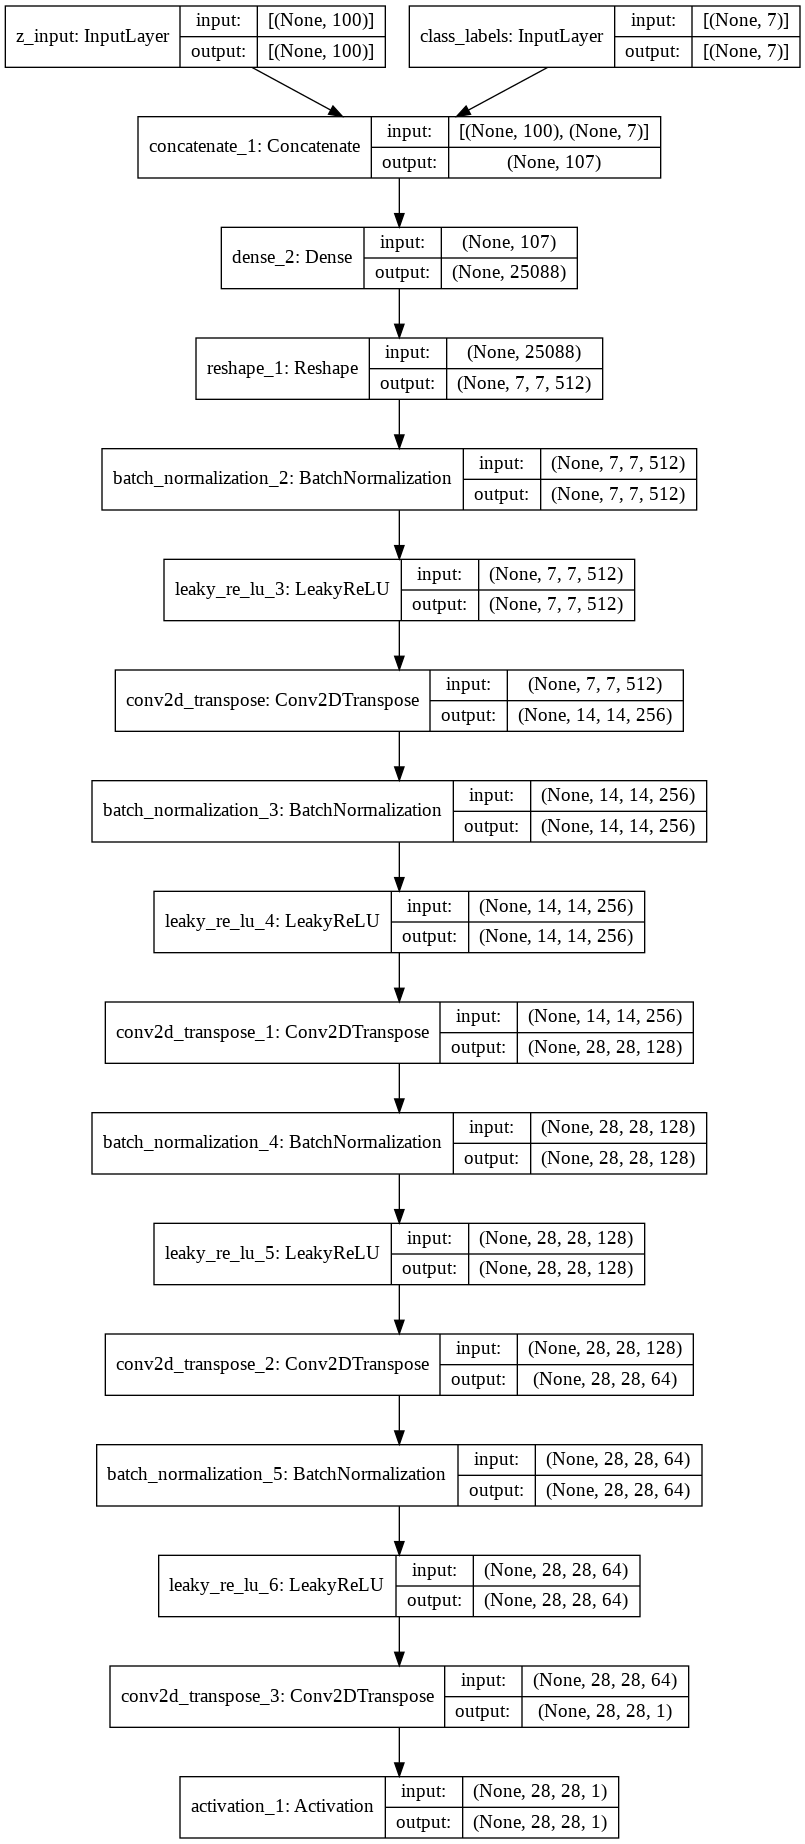

In [ ]:
from IPython.display import Image, display
display(Image('adversarial.png'))
print("---")
display(Image('discriminator.png'))
print("---")
display(Image('generator.png'))

In [ ]:
### test 3: impairing discriminator e riduzione spazio latente ###
# https://www.mathworks.com/help/deeplearning/ug/monitor-gan-training-progress-and-identify-common-failure-modes.html

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow.keras.backend as K


def loadDB():
    dir = "./fuse/"
    wopen = dir + "fuse"
    pickle_in = open(wopen+"X.pickle", "rb")
    datax = pickle.load(pickle_in)
    pickle_in = open(wopen+"Y.pickle", "rb")
    datay = pickle.load(pickle_in)
    datay = np.array(datay).reshape(-1)
    print("np.array db img shape: " + str(datax.shape))
    print("np.array db labels shape: " + str(datay.shape))
    return datax, datay


def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [256, 128, 64, 1]
    stride = 2
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0]*2)(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]*2))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 64:
            stride = 1
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=stride,
                            padding='same', kernel_initializer=init)(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 64]
    init = RandomNormal(mean=0.0, stddev=0.02)
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 1000
    save_model = 10000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    halfbatch = int(batch_size/2)
    valid = np.ones((halfbatch, 1))
    fake = np.zeros((halfbatch, 1))
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=halfbatch)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[halfbatch, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, halfbatch)]
        fake_images = generator.predict([noise, fake_labels])

        # train discriminator
        lossf = discriminator.train_on_batch([fake_images, fake_labels], fake)
        lossv = discriminator.train_on_batch([real_images, real_labels], valid)
        #loss, acc = discriminator.train_on_batch([x, labels], y)
        loss = 0.5 * np.add(lossf, lossv)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i+1, loss[0], loss[1])

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        loss = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f]" % (log, loss)
        if i == (train_steps - 1) or (i+1) % save_interval == 0:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
        if i == (train_steps - 1) or (i+1) % save_model == 0:
            # save the generator
            generator.save("gen")
            # test generator
            test_generator(generator, tag=(i+1))
    # in the end we save generator
    generator.save("gen")


def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%d.png" % step)
    images = generator.predict([noise_input, noise_class])
    #print(model_name, " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r, c) = (7, 3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(reuse):
    x_train, y_train = loadDB()
    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan"
    # network parameters
    latent_size = 80
    batch_size = 64
    train_steps = 200
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
        discriminator = load_model("dis")
    # print(discriminator.summary())

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
        generator = load_model("gen")
    # generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer)
    # adversarial.summary()

    # visual plot models
    # plot_model(generator, to_file='generator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(discriminator, to_file='discriminator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(adversarial, to_file='adversarial.png',
    #           show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, tag=0):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 80])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=False,
                step=tag,
                model_name="test_outputs")


if __name__ == '__main__':
    ### TRAIN CGAN ###
    build_and_train_models(reuse=False)



np.array db img shape: (121677, 28, 28, 1)
np.array db labels shape: (121677,)
20: [discriminator loss: 0.007916, acc: 1.000000] [adversarial loss: 0.597042]
INFO:tensorflow:Assets written to: gen/assets


In [ ]:
### test 4: images normalization [-1,1], meno filtri, diverso learning rate

np.array db img shape: (28709, 28, 28, 1)
np.array db labels shape: (28709,)
500: [discriminator loss: 0.031619, acc: 1.000000] [adversarial loss: 0.004076]


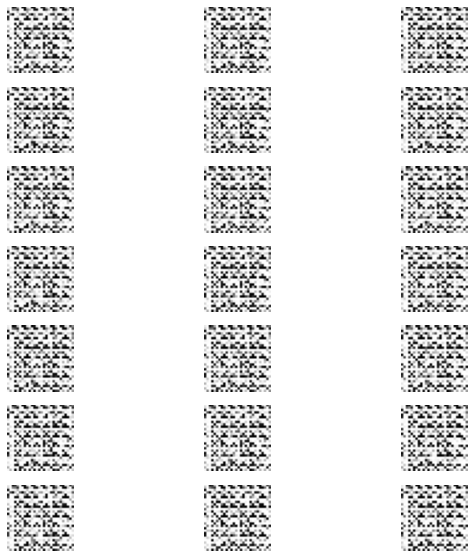

1000: [discriminator loss: 0.046230, acc: 1.000000] [adversarial loss: 0.071680]


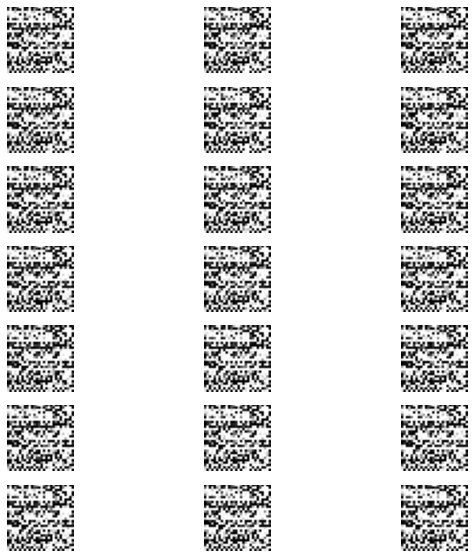

1500: [discriminator loss: 0.001845, acc: 1.000000] [adversarial loss: 0.012143]


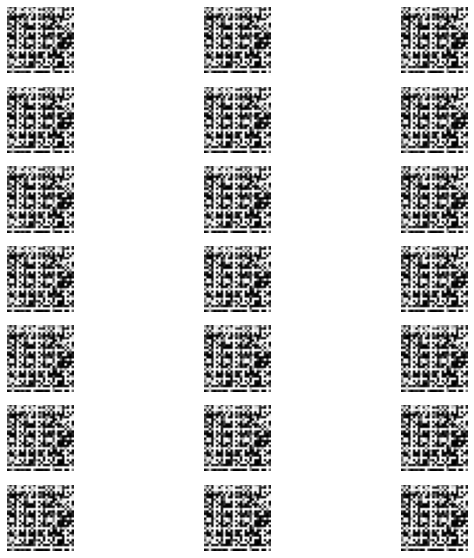

2000: [discriminator loss: 0.000414, acc: 1.000000] [adversarial loss: 0.006291]


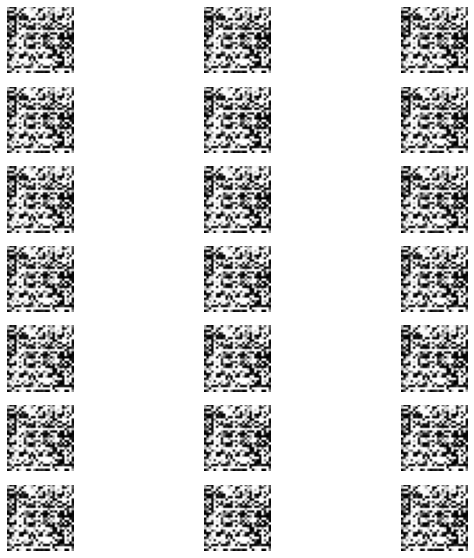

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow.keras.backend as K


def loadDB():
    dir = "./mma/"
    wopen = dir + "train"
    pickle_in = open(wopen+"X.pickle", "rb")
    datax = pickle.load(pickle_in)
    pickle_in = open(wopen+"Y.pickle", "rb")
    datay = pickle.load(pickle_in)
    datay = np.array(datay).reshape(-1)
    print("np.array db img shape: " + str(datax.shape))
    print("np.array db labels shape: " + str(datay.shape))
    return datax, datay


def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    stride = 2
    #init = RandomNormal(mean=0.0, stddev=0.02)
    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
    for filters in layer_filters:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if filters <= 32:
            stride = 1
            kernel_size = 3
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=stride,
                            padding='same')(x)
    x = Activation('tanh')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator


def build_discriminator(inputs, labels, image_size):
    kernel_size = 3
    layer_filters = [16, 32, 64]
    #init = RandomNormal(mean=0.0, stddev=0.02)
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    x = Conv2D(filters=layer_filters[0],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[1],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=layer_filters[2],
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator


def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 500
    save_model = 10000
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, latent_size])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    train_size = x_train.shape[0]
    halfbatch = int(batch_size/2)
    valid = np.ones((halfbatch, 1))
    fake = np.zeros((halfbatch, 1))
    #last_loss_d = 0
    #last_loss_adv = 0
    #last_accuracy = 0
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=halfbatch)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[halfbatch, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, halfbatch)]
        fake_images = generator.predict([noise, fake_labels])

        # train discriminator
        # if last_accuracy < 0.8 or last_loss_d < 0.1 or last_loss_adv > 0.3:
        lossf = discriminator.train_on_batch(
            [fake_images, fake_labels], fake)
        lossv = discriminator.train_on_batch(
            [real_images, real_labels], valid)
        loss = 0.5 * np.add(lossf, lossv)
        #last_loss_d = loss[0]
        #last_accuracy = loss[1]
        log = "%d: [discriminator loss: %f, acc: %.2f]" % (
            i+1, loss[0], loss[1])
        # else:
        #    log = "%d: [discriminator not trained, last loss: %f, last accuracy %.2f]" % (
        #        i+1, last_loss_d, last_accuracy)

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[
            np.random.choice(num_labels, batch_size)]
        y = np.ones([batch_size, 1])

        # train the adversarial network
        loss = adversarial.train_on_batch([noise, fake_labels], y)
        #last_loss_adv = loss
        log = "%s [adversarial loss: %f]" % (log, loss)
        if i == (train_steps - 1) or (i+1) % save_interval == 0:
            print(log)
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=True,
                        step=(i + 1),
                        model_name=model_name)
        if i == (train_steps - 1) or (i+1) % save_model == 0:
            # save the generator
            generator.save("gen")
            # test generator
            test_generator(generator, tag=(i+1))
    # in the end we save generator
    generator.save("gen")


def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%d.png" % step)
    images = generator.predict([noise_input, noise_class])
    # rescale images
    images = 0.5*images+0.5
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    (r, c) = (7, 3)
    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(reuse):
    x_train, y_train = loadDB()
    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    #x_train = x_train.astype('float32') / 255
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan"
    # network parameters
    latent_size = 100
    batch_size = 64
    train_steps = 2000000
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    discriminator.trainable = True
    optimizer = Adam(learning_rate=0.0001)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    if reuse == True:
        discriminator = load_model("dis")
    # print(discriminator.summary())

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    if reuse == True:
        generator = load_model("gen")
    # generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = Adam(learning_rate=0.0002)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels], outputs, name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer)
    # adversarial.summary()

    # visual plot models
    # plot_model(generator, to_file='generator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(discriminator, to_file='discriminator.png',
    #           show_shapes=True, show_layer_names=True)
    # plot_model(adversarial, to_file='adversarial.png',
    #           show_shapes=True, show_layer_names=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, tag=0):
    noise_input = np.random.uniform(-1.0, 1.0, size=[21, 100])
    noise_class = np.array([[1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [1., 0., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., 0., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 1., 0., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.],
                            [0., 0., 0., 0., 0., 0., 1.]])
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=False,
                step=tag,
                model_name="test_outputs")


if __name__ == '__main__':
    ### TRAIN CGAN ###
    build_and_train_models(reuse=False)
